##Prepare environment

Suggestions before you start working with Google Collab:

Copy the collab to your Google Drive for privacy reasons and to save your work:
	
	File -> Save a Copy in Drive.
	
Change runtime from CPU to GPU for faster training:
	
	Runtime -> Change Runtime Type -> T4 GPU


Connect to your Google Drive to save work.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


Clone directory to prepare working space.

In [4]:
!git clone https://github.com/meerimkanybekova/finetune_paddle_ocr.git

Cloning into 'finetune_paddle_ocr'...
remote: Enumerating objects: 166, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (155/155), done.
remote: Total 166 (delta 9), reused 161 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (166/166), 11.73 MiB | 14.58 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Updating files: 100% (121/121), done.


In [5]:
%cd finetune_paddle_ocr

/content/drive/MyDrive/finetune_paddle_ocr


Clone PaddleOCR and install nessesary libraries.

In [6]:
!git clone https://github.com/PaddlePaddle/PaddleOCR.git

Cloning into 'PaddleOCR'...
remote: Enumerating objects: 51048, done.
remote: Counting objects: 100% (1366/1366), done.
remote: Compressing objects: 100% (770/770), done.
remote: Total 51048 (delta 663), reused 1189 (delta 582), pack-reused 49682 (from 1)
Receiving objects: 100% (51048/51048), 385.27 MiB | 18.63 MiB/s, done.
Resolving deltas: 100% (35808/35808), done.
Updating files: 100% (2385/2385), done.


In [7]:
!pip install -q pyclipper lmdb rapidfuzz paddlepaddle-gpu paddleocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.9/758.9 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.5/407.5 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.3 MB/s eta 0:00:00


In [8]:
import os
import cv2
import json
import paddle
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image
from imutils import perspective
from paddleocr import PaddleOCR,draw_ocr

In [9]:
paddle.utils.run_check()

Running verify PaddlePaddle program ... 
PaddlePaddle works well on 1 GPU.
PaddlePaddle is installed successfully! Let's start deep learning with PaddlePaddle now.


Now, when all installation is done and you see "PaddlePaddle works well on 1 GPU." message. We are ready to start work!

##Data preparation

Example dataset for today's tutorial is https://www.kaggle.com/datasets/ipythonx/totaltextstr. You can download it, or just continue with the tutorial since shorter version of the dataset is already set up with the repository you cloned earlier for the convinience.

Next we will need to create the training and evaluation .txt files to prepare the dataset for training.

In [10]:
def prepare_detection_text_file(data_type, input_image_dir, annotation_dir, output_file):
    count = 0
    flag = 1

    for i in tqdm(os.listdir(input_image_dir)):
        img_path = os.path.join(input_image_dir, i)
        bounding_box_path = os.path.join(annotation_dir, "poly_gt_" + i.split(".")[0] + ".txt")

        with open(bounding_box_path, "r") as var:
            var = var.readlines()

        lis = []
        for j in var:
            try:
                j = j.replace("\n", '')
                x_coordinates = j.split(",")[0].split("[")[2].split("]")[0].split(" ")
                y_coordinates = j.split(",")[1].split("[")[2].split("]")[0].split(" ")

                if len(x_coordinates) != 4 or len(y_coordinates) != 4:
                    continue

                if j.split(" ")[-1] == "[]":
                    continue

                text = j.split(" ")[-1].split("'")[1]
                if "#" in text:
                    text = "###"

                x1, x2, x3, x4 = x_coordinates[0], x_coordinates[1], x_coordinates[2], x_coordinates[3]
                y1, y2, y3, y4 = y_coordinates[0], y_coordinates[1], y_coordinates[2], y_coordinates[3]

                dic = {
                    "points": [[x1, y1], [x2, y2], [x3, y3], [x4, y4]],
                    "transcription": str(text)
                }
                lis.append(dic)

            except:
                flag = 0

        lis = json.dumps(lis)

        if flag == 0:
            flag = 1
            continue

        if lis == [] or lis == "[]":
            continue

        with open(output_file, "a") as ob:
            ob.write(img_path + "\t" + str(lis) + "\n")

        count += 1

    print(f"\nTotal number of Annotations created for {data_type} are ", count)

In [11]:
prepare_detection_text_file(
    data_type="Training",
    input_image_dir="dataset/Total-Text/Train",
    annotation_dir="dataset/Total-Text/Annotation/groundtruth_polygonal_annotation/Train",
    output_file="dataset/detection_train.txt"
)

100%|██████████| 56/56 [00:00<00:00, 145.38it/s]


Total number of Annotations created for Training are  50


In [12]:
prepare_detection_text_file(
    data_type="Testing/Eval",
    input_image_dir="dataset/Total-Text/Test",
    annotation_dir="dataset/Total-Text/Annotation/groundtruth_polygonal_annotation/Test",
    output_file="dataset/detection_test.txt"
)

100%|██████████| 3/3 [00:00<00:00, 145.65it/s]


Total number of Annotations created for Testing/Eval are  2


Similar process is done with recognition dataset

In [13]:
def prepare_recognition_text_file(data_type, input_image_dir, annotation_dir, output_image_dir, output_file):
    if not os.path.exists(output_image_dir):
        os.makedirs(output_image_dir)

    count = 0
    flag = 1
    img_counter = 0

    for i in tqdm(os.listdir(input_image_dir)):
        img_path = os.path.join(input_image_dir, i)
        bounding_box_path = os.path.join(annotation_dir, "poly_gt_" + i.split(".")[0] + ".txt")

        with open(bounding_box_path, "r") as var:
            var = var.readlines()

        lis = []
        for j in var:
            try:
                j = j.replace("\n", '')
                x_coordinates = j.split(",")[0].split("[")[2].split("]")[0].split(" ")
                y_coordinates = j.split(",")[1].split("[")[2].split("]")[0].split(" ")

                if len(x_coordinates) != 4 or len(y_coordinates) != 4:
                    continue

                if j.split(" ")[-1] == "[]":
                    continue

                text = j.split(" ")[-1].split("'")[1]
                if "#" in text:
                    text = "###"

                x1, x2, x3, x4 = x_coordinates[0], x_coordinates[1], x_coordinates[2], x_coordinates[3]
                y1, y2, y3, y4 = y_coordinates[0], y_coordinates[1], y_coordinates[2], y_coordinates[3]

                dic = {
                    "points": [[x1, y1], [x2, y2], [x3, y3], [x4, y4]],
                    "transcription": str(text)
                }
                lis.append(dic)

                x1, y1, x2, y2, x3, y3, x4, y4 = int(x1), int(y1), int(x2), int(y2), int(x3), int(y3), int(x4), int(y4)
                pts = np.asarray([(x1, y1), (x2, y2), (x3, y3), (x4, y4)])

                img = cv2.imread(img_path)
                warped = perspective.four_point_transform(img, pts)

                new_img_path = os.path.join(output_image_dir, f"img_{img_counter}.png")
                cv2.imwrite(new_img_path, warped)

                with open(output_file, "a") as ob:
                    ob.write(new_img_path + "\t" + text + "\n")

                img_counter += 1

            except Exception as e:
                flag = 0
                print(f"Error processing {i}: {e}")

        if flag == 0:
            flag = 1
            continue

        count += 1

    print(f"\nTotal number of Annotations created for {data_type} are ", count)

In [14]:
prepare_recognition_text_file(
    data_type="Training",
    input_image_dir="dataset/Total-Text/Train",
    annotation_dir="dataset/Total-Text/Annotation/groundtruth_polygonal_annotation/Train",
    output_image_dir="dataset/crnn_train",
    output_file="dataset/recognition_train.txt"
)

100%|██████████| 56/56 [00:06<00:00,  9.20it/s]


Total number of Annotations created for Training are  56


In [15]:
prepare_recognition_text_file(
    data_type="Testing/Eval",
    input_image_dir="dataset/Total-Text/Test",
    annotation_dir="dataset/Total-Text/Annotation/groundtruth_polygonal_annotation/Test",
    output_image_dir="dataset/crnn_test",
    output_file="dataset/recognition_test.txt"
)

100%|██████████| 3/3 [00:00<00:00, 20.19it/s]


Total number of Annotations created for Testing/Eval are  3


##Get pretrained models

We get pretrained models from PaddleOCR website. From the link given in code other pretrained models can be found.

Detection

In [16]:
!wget -P pretrained_models/detection/ https://paddleocr.bj.bcebos.com/pretrained/MobileNetV3_large_x0_5_pretrained.pdparams

--2024-08-21 23:42:00--  https://paddleocr.bj.bcebos.com/pretrained/MobileNetV3_large_x0_5_pretrained.pdparams
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 103.235.47.176, 2409:8c04:1001:1203:0:ff:b0bb:4f27
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|103.235.47.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3189601 (3.0M) [application/octet-stream]
Saving to: ‘pretrained_models/detection/MobileNetV3_large_x0_5_pretrained.pdparams’

MobileNetV3_large_x 100%[===================>]   3.04M   529KB/s    in 8.3s    

2024-08-21 23:42:11 (376 KB/s) - ‘pretrained_models/detection/MobileNetV3_large_x0_5_pretrained.pdparams’ saved [3189601/3189601]



Recognition

In [17]:
!wget -P pretrained_models/recognition/ https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_rec_train.tar

--2024-08-21 23:42:11--  https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_rec_train.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 103.235.47.176, 2409:8c04:1001:1203:0:ff:b0bb:4f27
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|103.235.47.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 204093440 (195M) [application/x-tar]
Saving to: ‘pretrained_models/recognition/en_PP-OCRv3_rec_train.tar’

en_PP-OCRv3_rec_tra 100%[===================>] 194.64M  13.0MB/s    in 32s     

2024-08-21 23:42:44 (6.13 MB/s) - ‘pretrained_models/recognition/en_PP-OCRv3_rec_train.tar’ saved [204093440/204093440]



This command does the following:


1.   extracts the tar file
2.   places it in the recognition dir
3.   deletes the tar file

In [18]:
!tar -xf pretrained_models/recognition/en_PP-OCRv3_rec_train.tar -C pretrained_models/recognition && rm -rf pretrained_models/recognition/en_PP-OCRv3_rec_train.tar

## Configuration files

The files that contain all details about the training.

The files are in .yml format and are already set for the current training. You can adjust them in configs folder.

For example, epoch was set to 5 foryou to see the result faster. However, epoch should be set up to 500 or more depending on the size of the dataset.

The same goes with the training of recognition model, which epoch would be best to set at 1200.

## Training
Now, when datasets, models and config files are ready. Run the following commands to start training process.

Detection

In [20]:
!python3 PaddleOCR/tools/train.py -c configs/detection_config.yml

[2024/08/21 23:47:21] ppocr INFO: Architecture : 
[2024/08/21 23:47:21] ppocr INFO:     Backbone : 
[2024/08/21 23:47:21] ppocr INFO:         model_name : large
[2024/08/21 23:47:21] ppocr INFO:         name : MobileNetV3
[2024/08/21 23:47:21] ppocr INFO:         scale : 0.5
[2024/08/21 23:47:21] ppocr INFO:     Head : 
[2024/08/21 23:47:21] ppocr INFO:         k : 50
[2024/08/21 23:47:21] ppocr INFO:         name : DBHead
[2024/08/21 23:47:21] ppocr INFO:     Neck : 
[2024/08/21 23:47:21] ppocr INFO:         name : DBFPN
[2024/08/21 23:47:21] ppocr INFO:         out_channels : 256
[2024/08/21 23:47:21] ppocr INFO:     Transform : None
[2024/08/21 23:47:21] ppocr INFO:     algorithm : DB
[2024/08/21 23:47:21] ppocr INFO:     model_type : det
[2024/08/21 23:47:21] ppocr INFO: Eval : 
[2024/08/21 23:47:21] ppocr INFO:     dataset : 
[2024/08/21 23:47:21] ppocr INFO:         data_dir : ./
[2024/08/21 23:47:21] ppocr INFO:         label_file_list : ['dataset/detection_test.txt']
[2024/08/2

Recognition

In [21]:
!python3 PaddleOCR/tools/train.py -c configs/recognition_config.yml

[2024/08/21 23:49:21] ppocr INFO: Architecture : 
[2024/08/21 23:49:21] ppocr INFO:     Backbone : 
[2024/08/21 23:49:21] ppocr INFO:         last_conv_stride : [1, 2]
[2024/08/21 23:49:21] ppocr INFO:         last_pool_kernel_size : [2, 2]
[2024/08/21 23:49:21] ppocr INFO:         last_pool_type : avg
[2024/08/21 23:49:21] ppocr INFO:         name : MobileNetV1Enhance
[2024/08/21 23:49:21] ppocr INFO:         scale : 0.5
[2024/08/21 23:49:21] ppocr INFO:     Head : 
[2024/08/21 23:49:21] ppocr INFO:         head_list : 
[2024/08/21 23:49:21] ppocr INFO:             CTCHead : 
[2024/08/21 23:49:21] ppocr INFO:                 Head : 
[2024/08/21 23:49:21] ppocr INFO:                     fc_decay : 1e-05
[2024/08/21 23:49:21] ppocr INFO:                 Neck : 
[2024/08/21 23:49:21] ppocr INFO:                     depth : 2
[2024/08/21 23:49:21] ppocr INFO:                     dims : 64
[2024/08/21 23:49:21] ppocr INFO:                     hidden_dims : 120
[2024/08/21 23:49:21] ppocr I

##Evaluate

Convert models into inference to see the result of the training.

Detection

In [23]:
!python3 PaddleOCR/tools/export_model.py -c configs/detection_config.yml -o Global.pretrained_model=output/detection/latest Global.save_inference_dir=models/detection

W0821 23:51:06.047987  8265 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.5, Driver API Version: 12.2, Runtime API Version: 11.8
W0821 23:51:06.049305  8265 gpu_resources.cc:164] device: 0, cuDNN Version: 8.9.
[2024/08/21 23:51:06] ppocr INFO: load pretrain successful from output/detection/latest
I0821 23:51:10.563190  8265 program_interpreter.cc:212] New Executor is Running.
[2024/08/21 23:51:10] ppocr INFO: inference model is saved to models/detection/inference
[2024/08/21 23:51:10] ppocr INFO: Export inference config file to models/detection/inference.yml


Recognition

In [24]:
!python3 PaddleOCR/tools/export_model.py -c configs/recognition_config.yml -o Global.pretrained_model=output/recognition/latest.pdparams  Global.save_inference_dir=models/recognition

W0821 23:51:20.018922  8334 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.5, Driver API Version: 12.2, Runtime API Version: 11.8
W0821 23:51:20.019955  8334 gpu_resources.cc:164] device: 0, cuDNN Version: 8.9.
[2024/08/21 23:51:20] ppocr INFO: load pretrain successful from output/recognition/latest
I0821 23:51:23.617193  8334 program_interpreter.cc:212] New Executor is Running.
[2024/08/21 23:51:23] ppocr INFO: inference model is saved to models/recognition/inference
[2024/08/21 23:51:23] ppocr INFO: Export inference config file to models/recognition/inference.yml


## Inference Run

In [25]:
detection_model='models/detection'
recognition_model='models/recognition'

In [29]:
ocr = PaddleOCR(use_angle_cls=True,
                rec_model_dir=recognition_model,
                det_model_dir=detection_model,
                rec_char_dict_path='PaddleOCR/ppocr/utils/en_dict.txt',
                use_gpu=True,
                lang = 'en')

[2024/08/21 23:52:41] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='models/detection', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='models/recognition', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_char_dict_path='PaddleOCR/ppocr/utils/en_dict.txt', use_space_char

In [27]:
img_path = 'dataset/Total-Text/Test/img2.jpg'

[2024/08/21 23:52:10] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.5225932598114014
[2024/08/21 23:52:10] ppocr DEBUG: cls num  : 8, elapsed : 0.057204484939575195
[2024/08/21 23:52:10] ppocr DEBUG: rec_res num  : 8, elapsed : 0.05791044235229492


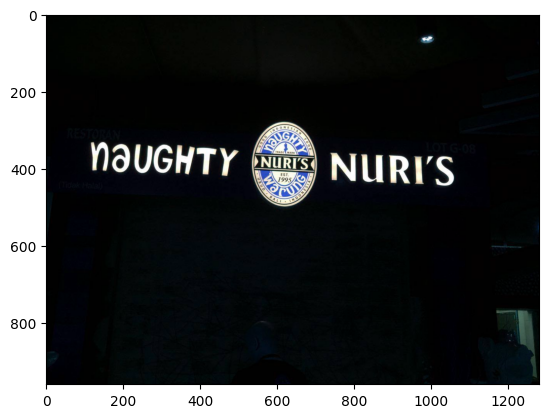

In [28]:
img = cv2.imread(img_path)
plt.imshow(img)
result = ocr.ocr(img)[0]

boxes = [line[0] for line in result]
txts = [line[1][0] for line in result]
scores = [line[1][1] for line in result]

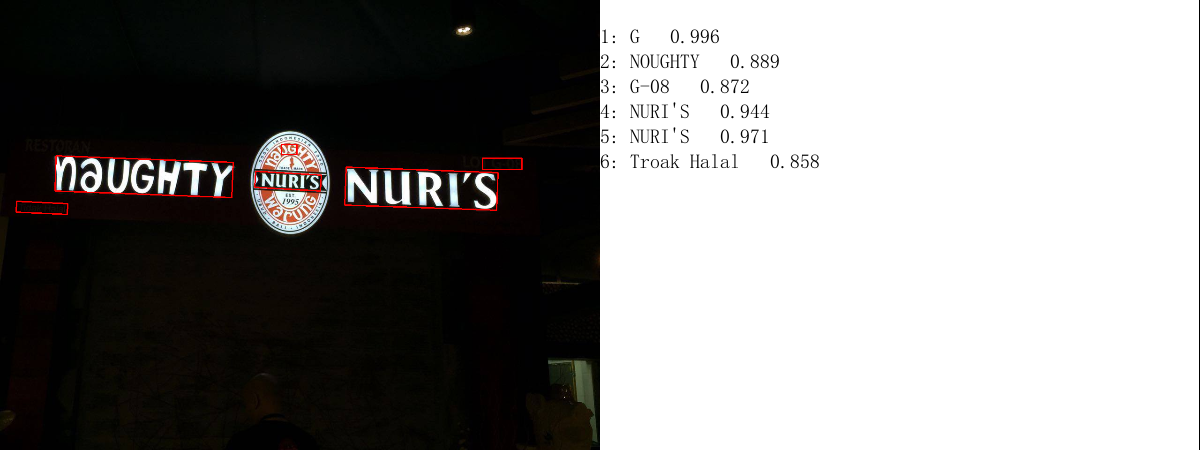

In [30]:
image = Image.open(img_path).convert('RGB')

im_show = draw_ocr(image, boxes, txts, scores, font_path='PaddleOCR/doc/fonts/simfang.ttf')
im_show = Image.fromarray(im_show)

im_show

Summary of the current state of your working directory:

We worked in finetune_paddle_ocr directory that you cloned in the beginning.

PaddleOCR repository was cloned to handle training, model extraction and all other functionalities.

Configs and dataset folders were cloned together with tutorial repository.

In the process, we downloaded pretrained_models and after training we got outputs which were then extracted into models.

And all these you already have saved in your Google Drive.

Tank you for your attention!

Do not hesitate to start experimenting with different data and changing config files.

You are very welcome to give suggestions and improvements.